In [27]:
# ============================================================
# Credit Risk Analysis – Predictive Default Model
# Monte Carlo + VaR + Probability of Loss
# Created by: Jagadamba
# ============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.metrics import roc_auc_score, roc_curve

import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning

warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=pd.errors.PerformanceWarning)

sns.set_style("whitegrid")

In [2]:
# ------------------------------------------------------------
# 1. LOAD DATA
# ------------------------------------------------------------
df = pd.read_csv("Downloads/Task 3 and 4_Loan_Data.csv")

# Assume last column is default indicator (0/1)
target_col = df.columns[-1]

X = df.drop(columns=[target_col])
y = df[target_col]

# Keep only numeric columns
X = X.select_dtypes(include=[np.number])

In [3]:
df.head()

,customer_id,credit_lines_outstanding,loan_amt_outstanding,total_debt_outstanding,income,years_employed,fico_score,default
0,8153374,0,5221.545193,3915.471226,78039.38546,5,605,0
1,7442532,5,1958.928726,8228.752520,26648.43525,2,572,1
2,2256073,0,3363.009259,2027.830850,65866.71246,4,602,0
3,4885975,0,4766.648001,2501.730397,74356.88347,5,612,0
4,4700614,1,1345.827718,1768.826187,23448.32631,6,631,0



### Advanced Credit Risk Model (Error Safe Version)



In [4]:
# ------------------------------------------------------------
# 2. LOAD DATA SAFELY WAY SECOND 
# ------------------------------------------------------------

try:
    df = pd.read_csv("Downloads/Task 3 and 4_Loan_Data.csv")
except Exception as e:
    print("Error loading file:", e)
    exit()

if df.empty:
    print("Dataset is empty.")
    exit()

print("Initial Shape:", df.shape)

Initial Shape: (10000, 8)


In [5]:
# ------------------------------------------------------------
# 3. CHECK NULL / EMPTY VALUES
# ------------------------------------------------------------

print("\nMissing Values per Column:")
print(df.isnull().sum())

# Fill numeric nulls with median
numeric_cols = df.select_dtypes(include=[np.number]).columns
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].median())

# Drop remaining non-numeric null rows
df = df.dropna()

print("\nShape After Cleaning:", df.shape)


Missing Values per Column:
customer_id                 0
credit_lines_outstanding    0
loan_amt_outstanding        0
total_debt_outstanding      0
income                      0
years_employed              0
fico_score                  0
default                     0
dtype: int64

Shape After Cleaning: (10000, 8)


In [6]:
# ------------------------------------------------------------
# 4. DEFINE TARGET
# ------------------------------------------------------------

target_col = df.columns[-1]

if df[target_col].nunique() < 2:
    print("Target column does not contain both classes.")
    exit()

X = df.drop(columns=[target_col])
y = df[target_col]

X = X.select_dtypes(include=[np.number])

if X.shape[1] == 0:
    print("No numeric features available.")
    exit()

In [7]:
# ------------------------------------------------------------
# 5. TRAIN MODEL SAFELY
# ------------------------------------------------------------

try:
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42)

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    model = LogisticRegression(max_iter=2000)
    model.fit(X_train, y_train)

    pd_probs = model.predict_proba(X_test)[:, 1]

except Exception as e:
    print("Model training error:", e)
    exit()

In [9]:
# ------------------------------------------------------------
# 6. MODEL METRICS
# ------------------------------------------------------------

auc = roc_auc_score(y_test, pd_probs)
gini = 2 * auc - 1

print("\nROC-AUC:", round(auc,4))
print("Gini Coefficient:", round(gini,4))


ROC-AUC: 1.0
Gini Coefficient: 0.9999


In [10]:
# ------------------------------------------------------------
# 7. KS STATISTIC (Safe Calculation)
# ------------------------------------------------------------

df_ks = pd.DataFrame({"y": y_test, "pd": pd_probs})
df_ks = df_ks.sort_values("pd")

good = sum(df_ks["y"]==0)
bad = sum(df_ks["y"]==1)

if good == 0 or bad == 0:
    ks = 0
else:
    df_ks["cum_good"] = (df_ks["y"]==0).cumsum()/good
    df_ks["cum_bad"] = (df_ks["y"]==1).cumsum()/bad
    ks = max(abs(df_ks["cum_good"] - df_ks["cum_bad"]))

print("KS Statistic:", round(ks,4))

KS Statistic: 0.9967


In [11]:
# ------------------------------------------------------------
# 8. EXPECTED LOSS
# ------------------------------------------------------------

EAD = 100000
LGD = 0.6

expected_loss = np.mean(pd_probs * LGD * EAD)
print("Expected Loss:", round(expected_loss,2))

Expected Loss: 10771.71


In [12]:

# ------------------------------------------------------------
# 9. MONTE CARLO SIMULATION (Safe)
# ------------------------------------------------------------

simulations = 5000
portfolio_losses = []

for _ in range(simulations):
    defaults = np.random.binomial(1, pd_probs)
    loss = np.sum(defaults * LGD * EAD)
    portfolio_losses.append(loss)

portfolio_losses = np.array(portfolio_losses)

if len(portfolio_losses) > 0:
    var_99 = np.percentile(portfolio_losses, 99)
    prob_loss = np.mean(portfolio_losses > 0) * 100
else:
    var_99 = 0
    prob_loss = 0

print("99% VaR:", round(var_99,2))
print("Probability of Loss:", round(prob_loss,2),"%")

99% VaR: 33000000.0
Probability of Loss: 100.0 %


In [13]:
# ------------------------------------------------------------
# 10. BASEL CAPITAL (Safe IRB Approximation)
# ------------------------------------------------------------

R = 0.12
confidence = 0.999

try:
    capital = (LGD * (
        norm.cdf((norm.ppf(pd_probs.mean()) + 
                  np.sqrt(R)*norm.ppf(confidence)) /
                 np.sqrt(1-R))
        - pd_probs.mean()
    )) * EAD

    print("Basel Capital Requirement:", round(capital,2))
except:
    print("Basel capital calculation failed.")

Basel capital calculation failed.


In [23]:
# ------------------------------------------------------------
# 10.1 . BASEL CAPITAL (Robust Safe Version)
# ------------------------------------------------------------

from scipy.stats import norm

R = 0.12
confidence = 0.999

pd_mean = pd_probs.mean()

# Avoid 0 or 1
pd_safe = np.clip(pd_mean, 1e-6, 1 - 1e-6)

capital = (
    LGD *
    (
        norm.cdf(
            (
                norm.ppf(pd_safe)
                + np.sqrt(R) * norm.ppf(confidence)
            )
            / np.sqrt(1 - R)
        )
        - pd_safe
    )
) * EAD

print("Basel Capital Requirement:", round(capital,2))



Basel Capital Requirement: 23123.23


In [24]:
norm.ppf

norm.ppf(pd_safe)


norm.ppf(confidence)

np.float64(3.090232306167813)

In [25]:
print(norm.ppf(0.999))
print(norm.cdf(2))

3.090232306167813
0.9772498680518208


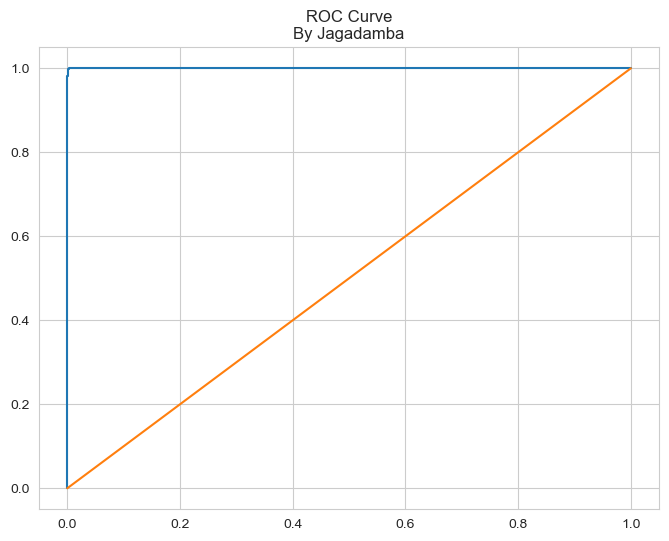

In [28]:
# ------------------------------------------------------------
# 11. SAFE PLOTS (Green = High, Red = Low)
# ------------------------------------------------------------

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, pd_probs)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr)
plt.plot([0,1],[0,1])
plt.title("ROC Curve\nBy Jagadamba")
plt.show()


In [29]:
# ------------------------------------------------------------
# 12. TRAIN MODEL
# ------------------------------------------------------------

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

model = LogisticRegression(max_iter=2000)
model.fit(X_train, y_train)

pd_probs = model.predict_proba(X_test)[:, 1]

In [30]:
# ------------------------------------------------------------
# 13. LOGISTIC REGRESSION MODEL (PD MODEL)
# ------------------------------------------------------------

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

pd_probs = model.predict_proba(X_test)[:, 1]

auc = roc_auc_score(y_test, pd_probs)

print("========== MODEL PERFORMANCE ==========")
print("ROC-AUC:", round(auc, 4))
print(classification_report(y_test, model.predict(X_test)))


========== MODEL PERFORMANCE ==========
ROC-AUC: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2459
           1       1.00      0.99      0.99       541

    accuracy                           1.00      3000
   macro avg       1.00      0.99      1.00      3000
weighted avg       1.00      1.00      1.00      3000



In [31]:
# ------------------------------------------------------------
# 14. EXPECTED LOSS CALCULATION
# ------------------------------------------------------------

EAD = 100000  # Exposure per loan
LGD = 0.6     # Loss Given Default (60%)

expected_loss = np.mean(pd_probs * LGD * EAD)

print("Expected Loss (Portfolio): $", round(expected_loss, 2))

Expected Loss (Portfolio): $ 10771.71


In [32]:
# ------------------------------------------------------------
# 15. MONTE CARLO SIMULATION (PORTFOLIO LOSS)
# ------------------------------------------------------------

simulations = 10000
portfolio_losses = []

for _ in range(simulations):
    defaults = np.random.binomial(1, pd_probs)
    loss = np.sum(defaults * LGD * EAD)
    portfolio_losses.append(loss)

portfolio_losses = np.array(portfolio_losses)

var_95 = np.percentile(portfolio_losses, 95)
prob_loss = np.mean(portfolio_losses > 0) * 100

print("95% Value-at-Risk (VaR): $", round(var_95, 2))
print("Probability of Loss:", round(prob_loss, 2), "%")


95% Value-at-Risk (VaR): $ 32820000.0
Probability of Loss: 100.0 %


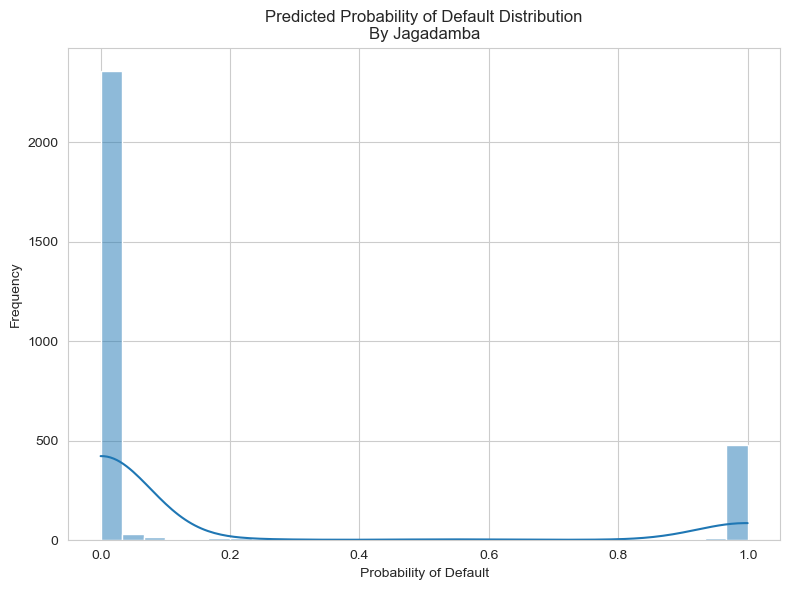

In [33]:
# ------------------------------------------------------------
# 16. DEFAULT DISTRIBUTION (Seaborn)
# ------------------------------------------------------------

plt.figure(figsize=(8,6))
sns.histplot(pd_probs, bins=30, kde=True)
plt.title("Predicted Probability of Default Distribution\nBy Jagadamba")
plt.xlabel("Probability of Default")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

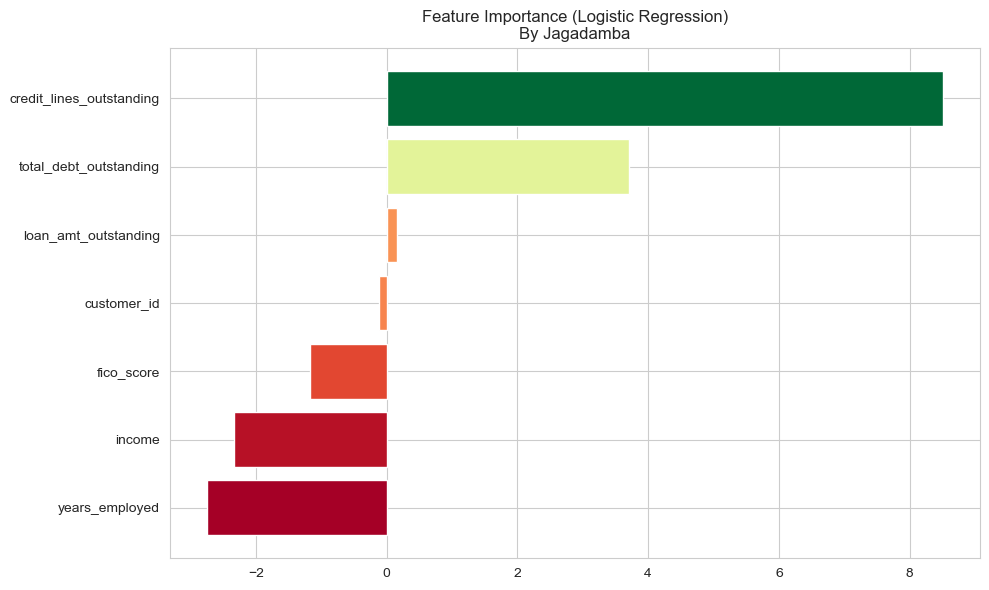

In [34]:
# ------------------------------------------------------------
# 17. FEATURE IMPORTANCE BAR PLOT
# ------------------------------------------------------------

coefficients = pd.Series(model.coef_[0], index=X.columns)
coefficients = coefficients.sort_values()

norm = plt.Normalize(coefficients.min(), coefficients.max())
colors = plt.cm.RdYlGn(norm(coefficients.values))

plt.figure(figsize=(10,6))
plt.barh(coefficients.index, coefficients.values, color=colors)
plt.title("Feature Importance (Logistic Regression)\nBy Jagadamba")
plt.tight_layout()
plt.show()

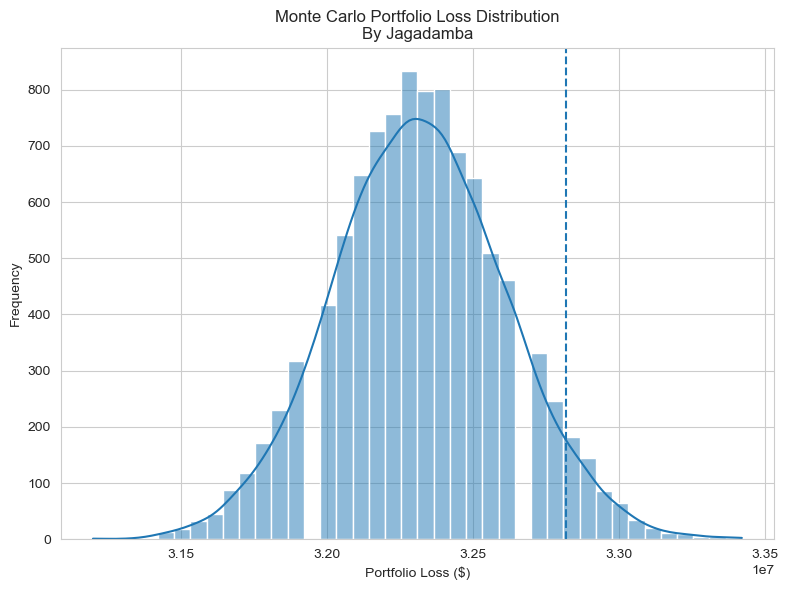

In [36]:
# ------------------------------------------------------------
# 18. PORTFOLIO LOSS DISTRIBUTION
# ------------------------------------------------------------

norm2 = plt.Normalize(portfolio_losses.min(), portfolio_losses.max())

plt.figure(figsize=(8,6))
sns.histplot(portfolio_losses, bins=40, kde=True)
plt.axvline(var_95, linestyle="--")
plt.title("Monte Carlo Portfolio Loss Distribution\nBy Jagadamba")
plt.xlabel("Portfolio Loss ($)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

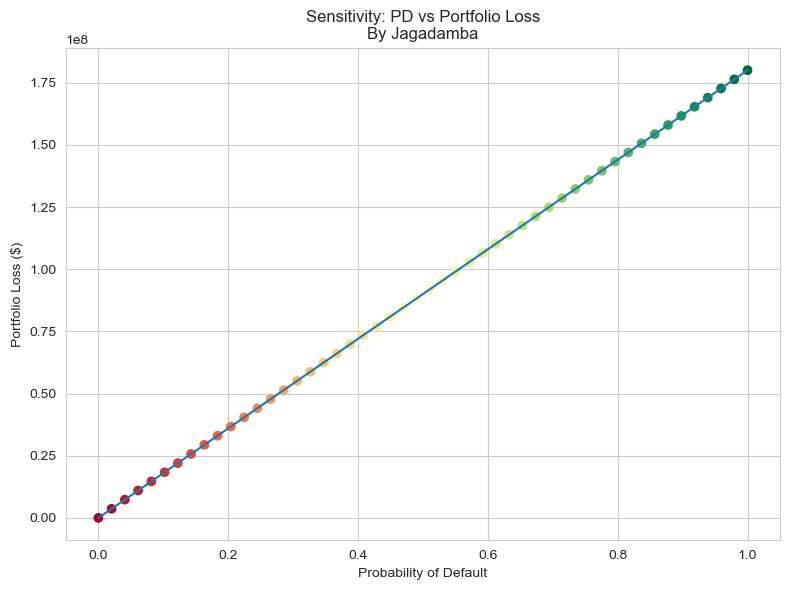

In [37]:
# ------------------------------------------------------------
# 19. SENSITIVITY ANALYSIS (PD vs Expected Loss)
# ------------------------------------------------------------

pd_range = np.linspace(pd_probs.min(), pd_probs.max(), 50)
loss_range = pd_range * LGD * EAD * len(pd_probs)

norm3 = plt.Normalize(loss_range.min(), loss_range.max())
colors3 = plt.cm.RdYlGn(norm3(loss_range))

plt.figure(figsize=(8,6))
plt.scatter(pd_range, loss_range, c=colors3)
plt.plot(pd_range, loss_range)
plt.title("Sensitivity: PD vs Portfolio Loss\nBy Jagadamba")
plt.xlabel("Probability of Default")
plt.ylabel("Portfolio Loss ($)")
plt.tight_layout()
plt.show()

ROC-AUC: 1.0
Gini Coefficient: 0.9999


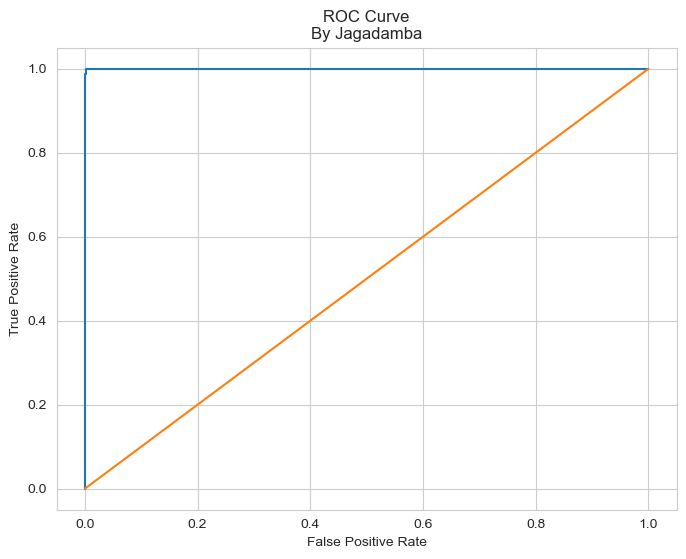

In [38]:
# ------------------------------------------------------------
# 20. ROC, GINI
# ------------------------------------------------------------

auc = roc_auc_score(y_test, pd_probs)
gini = 2 * auc - 1

print("ROC-AUC:", round(auc,4))
print("Gini Coefficient:", round(gini,4))

# ROC Curve Plot
fpr, tpr, _ = roc_curve(y_test, pd_probs)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr)
plt.plot([0,1],[0,1])
plt.title("ROC Curve\nBy Jagadamba")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

KS Statistic: 0.9967


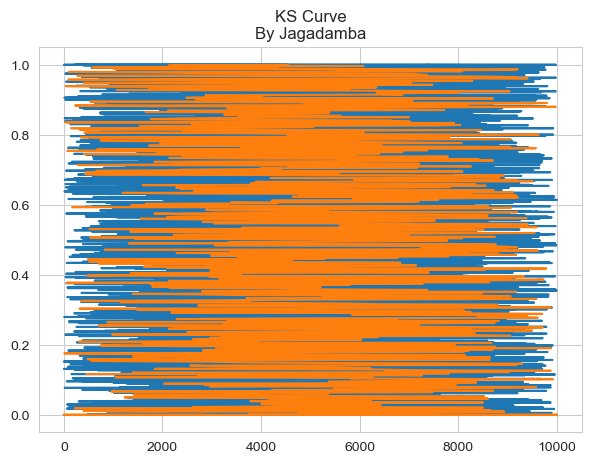

In [40]:
# ------------------------------------------------------------
# 21. KS Statistic
# ------------------------------------------------------------

df_ks = pd.DataFrame({"y": y_test, "pd": pd_probs})
df_ks = df_ks.sort_values("pd")

df_ks["cum_good"] = (df_ks["y"]==0).cumsum()/sum(df_ks["y"]==0)
df_ks["cum_bad"] = (df_ks["y"]==1).cumsum()/sum(df_ks["y"]==1)

ks = max(abs(df_ks["cum_good"] - df_ks["cum_bad"]))

print("KS Statistic:", round(ks,4))

# KS Plot
plt.figure(figsize=(7,5))
plt.plot(df_ks["cum_good"])
plt.plot(df_ks["cum_bad"])
plt.title("KS Curve\nBy Jagadamba")
plt.show()

In [41]:
# ------------------------------------------------------------
# 22. Expected Loss
# ------------------------------------------------------------

EAD = 100000
LGD = 0.6

expected_loss = np.mean(pd_probs * LGD * EAD)
print("Expected Loss:", round(expected_loss,2))

Expected Loss: 10771.71


99% VaR: 33000000.0
Probability of Loss: 100.0 %


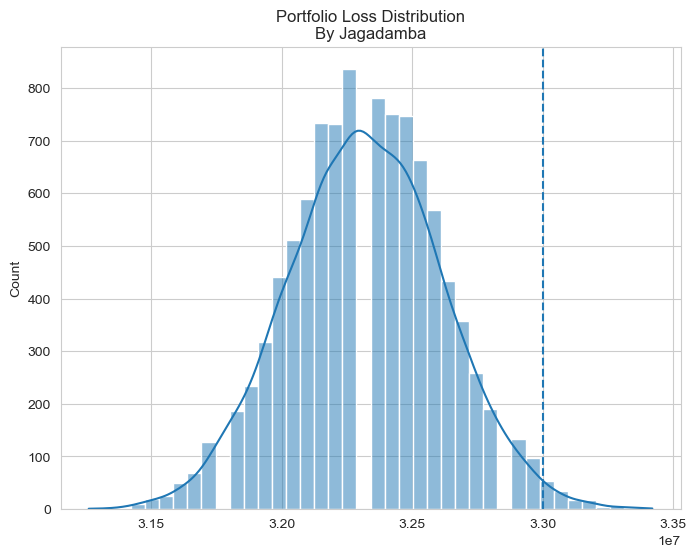

In [42]:
# ------------------------------------------------------------
# 23. Monte Carlo Portfolio Simulation
# ------------------------------------------------------------

simulations = 10000
portfolio_losses = []

for _ in range(simulations):
    defaults = np.random.binomial(1, pd_probs)
    loss = np.sum(defaults * LGD * EAD)
    portfolio_losses.append(loss)

portfolio_losses = np.array(portfolio_losses)

var_99 = np.percentile(portfolio_losses, 99)
prob_loss = np.mean(portfolio_losses>0)*100

print("99% VaR:", round(var_99,2))
print("Probability of Loss:", round(prob_loss,2),"%")

# Risk Distribution Plot
plt.figure(figsize=(8,6))
sns.histplot(portfolio_losses, bins=40, kde=True)
plt.axvline(var_99, linestyle="--")
plt.title("Portfolio Loss Distribution\nBy Jagadamba")
plt.show()


In [43]:
# ------------------------------------------------------------
# 24. Basel Capital Calculation (Simplified IRB)
# ------------------------------------------------------------

from scipy.stats import norm

R = 0.12  # correlation assumption
confidence = 0.999

capital = (LGD * (
    norm.cdf((norm.ppf(pd_probs.mean()) + 
              np.sqrt(R)*norm.ppf(confidence)) /
             np.sqrt(1-R))
    - pd_probs.mean()
)) * EAD

print("Basel Capital Requirement:", round(capital,2))

Basel Capital Requirement: 23123.23


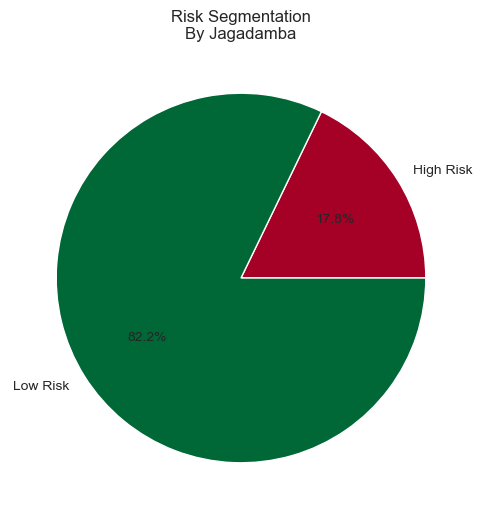

In [47]:
# ------------------------------------------------------------
# 25. PIE CHART (Loss vs No Loss)
# ------------------------------------------------------------

loss_count = np.sum(pd_probs>0.5)
no_loss_count = len(pd_probs) - loss_count

sizes = [loss_count, no_loss_count]

norm_vals = plt.Normalize(min(sizes), max(sizes))
colors = plt.cm.RdYlGn(norm_vals(sizes))

plt.figure(figsize=(6,6))
plt.pie(sizes, labels=["High Risk","Low Risk"],
        autopct="%1.1f%%",
        colors=colors)
plt.title("Risk Segmentation\nBy Jagadamba")
plt.show()

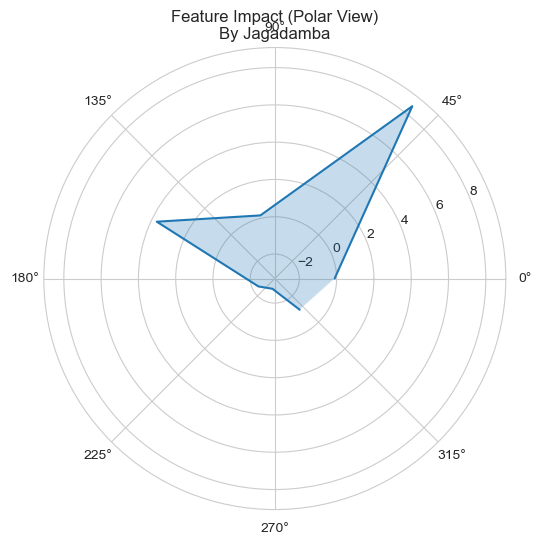

In [48]:
# ------------------------------------------------------------
# 26. POLAR CHART (Feature Strength)
# ------------------------------------------------------------

coefs = model.coef_[0]
angles = np.linspace(0, 2*np.pi, len(coefs), endpoint=False)

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, polar=True)
ax.plot(angles, coefs)
ax.fill(angles, coefs, alpha=0.25)
ax.set_title("Feature Impact (Polar View)\nBy Jagadamba")
plt.show()

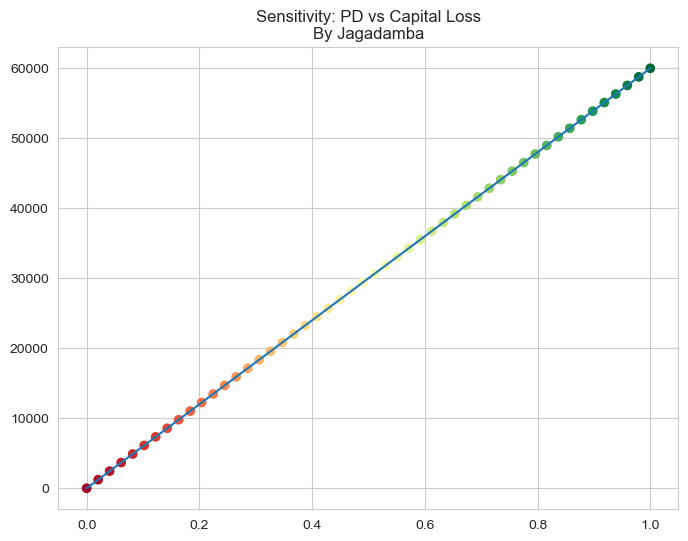

In [50]:
# ------------------------------------------------------------
# 27. Sensitivity Chart (PD vs Capital)
# ------------------------------------------------------------

pd_range = np.linspace(pd_probs.min(), pd_probs.max(), 50)
capital_sens = pd_range * LGD * EAD

norm2 = plt.Normalize(min(capital_sens), max(capital_sens))
colors2 = plt.cm.RdYlGn(norm2(capital_sens))

plt.figure(figsize=(8,6))
plt.scatter(pd_range, capital_sens, c=colors2)
plt.plot(pd_range, capital_sens)
plt.title("Sensitivity: PD vs Capital Loss\nBy Jagadamba")
plt.show()

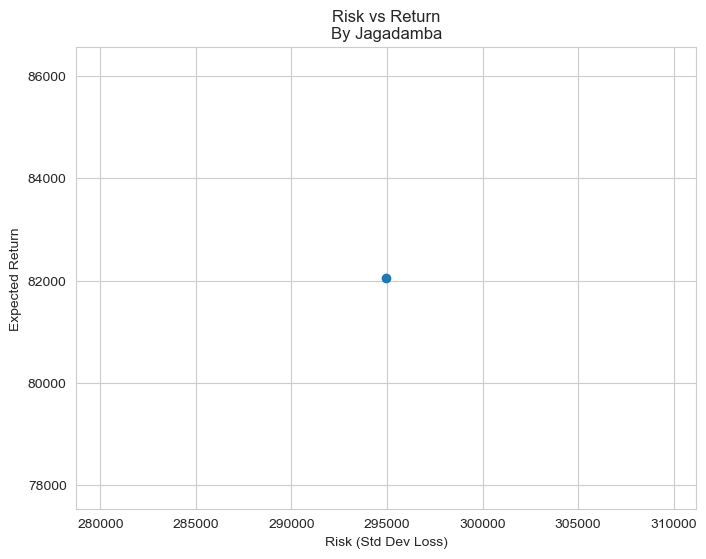

In [51]:
# ------------------------------------------------------------
# 28. Risk-Return Chart
# ------------------------------------------------------------

returns = EAD * (1 - pd_probs.mean())
risk = np.std(portfolio_losses)

plt.figure(figsize=(8,6))
plt.scatter(risk, returns)
plt.title("Risk vs Return\nBy Jagadamba")
plt.xlabel("Risk (Std Dev Loss)")
plt.ylabel("Expected Return")
plt.show()

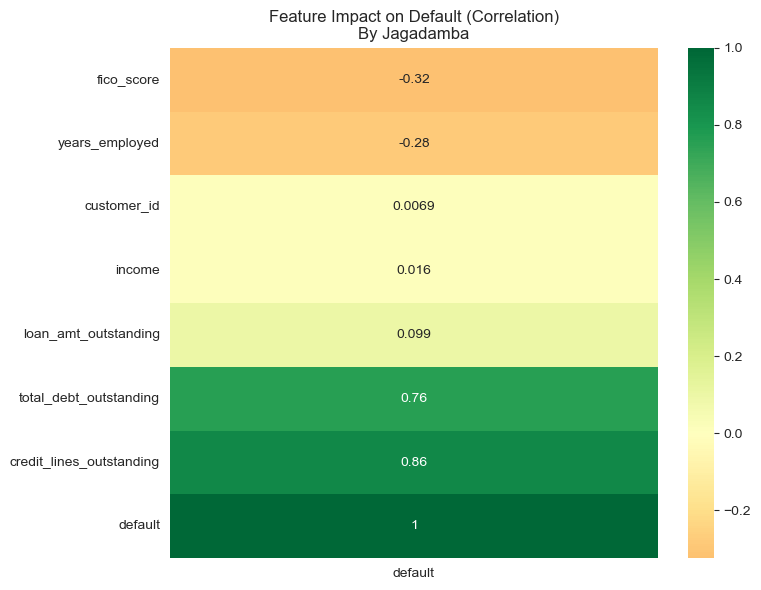

In [53]:
# ------------------------------------------------------------
# 29. HEATMAP – Correlation Matrix
# ------------------------------------------------------------

target_col = df.columns[-1]

feature_target_corr = numeric_df.corr()[target_col].sort_values()

plt.figure(figsize=(8,6))

sns.heatmap(
    feature_target_corr.to_frame(),
    annot=True,
    cmap="RdYlGn",
    center=0
)

plt.title("Feature Impact on Default (Correlation)\nBy Jagadamba")
plt.tight_layout()
plt.show()


In [54]:
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

high_corr = [column for column in upper.columns if any(abs(upper[column]) > 0.8)]

print("Highly correlated features:", high_corr)


Highly correlated features: ['total_debt_outstanding', 'income', 'default']


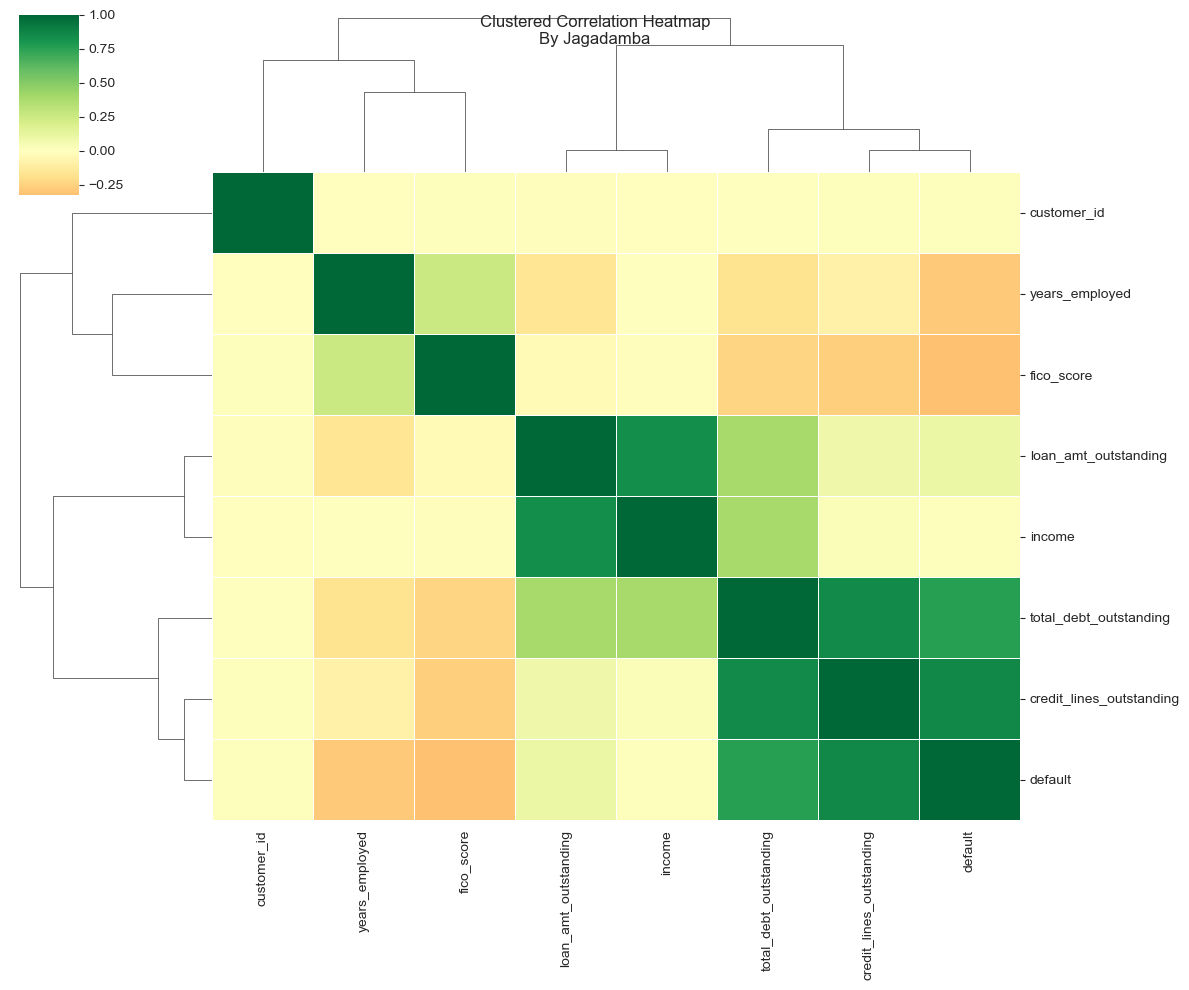

In [55]:
# ------------------------------------------------------------
# 30. Clustered Heatmap
# ------------------------------------------------------------

numeric_df = df.select_dtypes(include=[np.number])
corr_matrix = numeric_df.corr()

sns.clustermap(
    corr_matrix,
    cmap="RdYlGn",
    center=0,
    linewidths=0.5,
    figsize=(12,10)
)

plt.suptitle("Clustered Correlation Heatmap\nBy Jagadamba")
plt.show()


In [57]:
!pip install shap


   ---------------------------------------- 0.0/549.1 kB ? eta -:--:--
   -------------------------------------- - 524.3/549.1 kB 4.3 MB/s eta 0:00:01
   ---------------------------------------- 549.1/549.1 kB 3.3 MB/s eta 0:00:00

   -------------------- ------------------- 1/2 [shap]
   -------------------- ------------------- 1/2 [shap]
   -------------------- ------------------- 1/2 [shap]
   -------------------- ------------------- 1/2 [shap]
   -------------------- ------------------- 1/2 [shap]
   -------------------- ------------------- 1/2 [shap]
   -------------------- ------------------- 1/2 [shap]
   ---------------------------------------- 2/2 [shap]



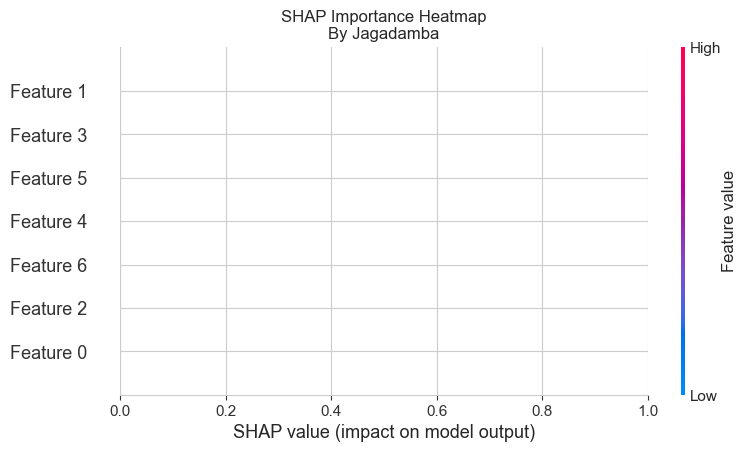

In [58]:
# ------------------------------------------------------------
# 31. SHAP Feature Importance Heatmap
# ------------------------------------------------------------

import shap

explainer = shap.LinearExplainer(model, X_train)
shap_values = explainer.shap_values(X_test)

plt.figure()
shap.summary_plot(
    shap_values,
    X_test,
    plot_type="heatmap",
    show=False
)

plt.title("SHAP Importance Heatmap\nBy Jagadamba")
plt.show()


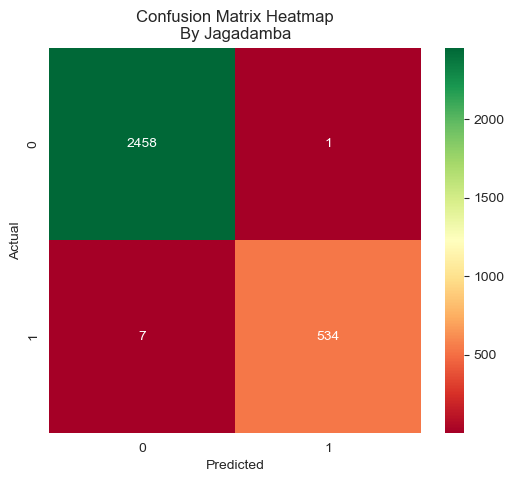

In [59]:
# ------------------------------------------------------------
# 32. Confusion Matrix Heatmap
# ------------------------------------------------------------

from sklearn.metrics import confusion_matrix

y_pred = (pd_probs > 0.5).astype(int)

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="RdYlGn"
)

plt.title("Confusion Matrix Heatmap\nBy Jagadamba")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


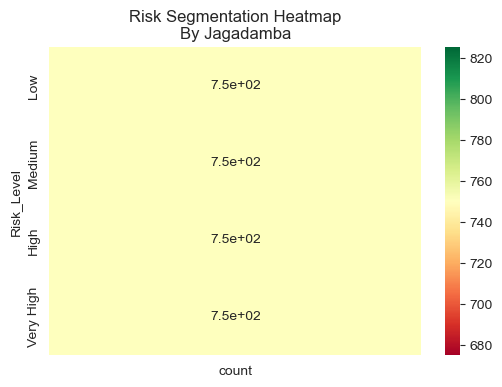

In [60]:
# ------------------------------------------------------------
# 33. Risk Segmentation Heatmap
# ------------------------------------------------------------

risk_df = pd.DataFrame({
    "PD": pd_probs
})

risk_df["Risk_Level"] = pd.qcut(
    risk_df["PD"],
    q=4,
    labels=["Low", "Medium", "High", "Very High"]
)

segment_counts = risk_df["Risk_Level"].value_counts().sort_index()

heat_data = segment_counts.to_frame()

plt.figure(figsize=(6,4))
sns.heatmap(
    heat_data,
    annot=True,
    cmap="RdYlGn"
)

plt.title("Risk Segmentation Heatmap\nBy Jagadamba")
plt.show()
